# Import Libaries

In [1]:
from sklearn.metrics import auc, mean_squared_error, r2_score, mean_poisson_deviance
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import utils
import torch
import architecture as archit

c:\Users\dylan\anaconda3\envs\flower\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read in data

In [2]:
def load_individual_data(agent_id):
      MY_DATA_PATH = '../data'
      X_train_sc = pd.read_csv(MY_DATA_PATH + '/X_train_' + str(agent_id) + '.csv')
      X_column_names = X_train_sc.columns.tolist()

      y_tr = pd.read_csv(MY_DATA_PATH + '/y_tr_' + str(agent_id) +  '.csv')

      X_val_sc = pd.read_csv(MY_DATA_PATH + '/X_val_' + str(agent_id) + '.csv')
      y_vl = pd.read_csv(MY_DATA_PATH + '/y_vl_' + str(agent_id) + '.csv')

      X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
      y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')

      # Created tensordataset
      train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_train_sc.values).float(), torch.tensor(y_tr.values).float())
      val_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_val_sc.values).float(), torch.tensor(y_vl.values).float())
      test_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_test_sc.values).float(), torch.tensor(y_te.values).float())
      
      return (train_dataset, val_dataset, test_dataset, X_train_sc, y_tr, X_val_sc, y_vl, X_test_sc, y_te)

In [3]:
train_dataset, val_dataset, test_dataset, X_train_sc, y_tr, X_val_sc, y_vl, X_test_sc, y_te = load_individual_data(1) 

# Read in models

In [4]:
NUM_FEATURES = 39

In [5]:
# Federated Model
fl_model = archit.NeuralNetworks(NUM_FEATURES)

model_name = 'fl_model.pt'
AGENT_PATH = '../ag_1/' + model_name 

fl_model.load_state_dict(torch.load(AGENT_PATH))
fl_model.eval()

NeuralNetworks(
  (hid1): Linear(in_features=39, out_features=5, bias=True)
  (hid2): Linear(in_features=5, out_features=10, bias=True)
  (hid3): Linear(in_features=10, out_features=15, bias=True)
  (drop): Dropout(p=0.12409392594394411, inplace=False)
  (output): Linear(in_features=15, out_features=1, bias=True)
)

In [6]:
# Local model
local_model = archit.NeuralNetworks(NUM_FEATURES)

model_name = 'local_model.pt'
AGENT_PATH = '../ag_1/' + model_name 

local_model.load_state_dict(torch.load(AGENT_PATH))
local_model.eval()

NeuralNetworks(
  (hid1): Linear(in_features=39, out_features=5, bias=True)
  (hid2): Linear(in_features=5, out_features=10, bias=True)
  (hid3): Linear(in_features=10, out_features=15, bias=True)
  (drop): Dropout(p=0.12409392594394411, inplace=False)
  (output): Linear(in_features=15, out_features=1, bias=True)
)

# Lorenz Curves

In [7]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    y_true = y_true.reshape((135603, ))
    y_pred = y_pred.reshape((135603, ))
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    
    return cumulated_exposure, cumulated_claims

In [15]:
for model in [fl_model, local_model]:
    print(model)

NeuralNetworks(
  (hid1): Linear(in_features=39, out_features=5, bias=True)
  (hid2): Linear(in_features=5, out_features=10, bias=True)
  (hid3): Linear(in_features=10, out_features=15, bias=True)
  (drop): Dropout(p=0.12409392594394411, inplace=False)
  (output): Linear(in_features=15, out_features=1, bias=True)
)
NeuralNetworks(
  (hid1): Linear(in_features=39, out_features=5, bias=True)
  (hid2): Linear(in_features=5, out_features=10, bias=True)
  (hid3): Linear(in_features=10, out_features=15, bias=True)
  (drop): Dropout(p=0.12409392594394411, inplace=False)
  (output): Linear(in_features=15, out_features=1, bias=True)
)


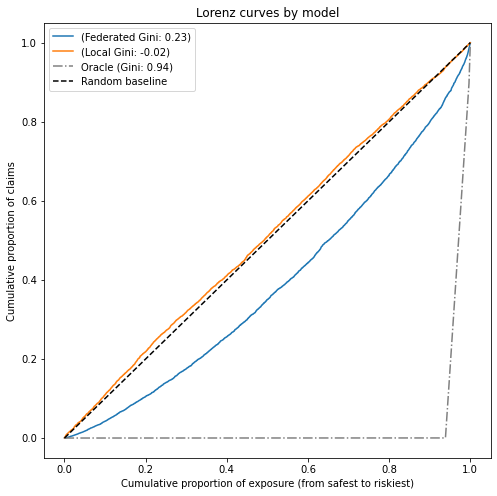

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

for model in [fl_model]:
    log_y_pred = []
    with torch.no_grad():
        model.eval()
        log_y_pred = model(torch.tensor(X_test_sc.values).float())
    log_y_pred = [a.squeeze().tolist() for a in log_y_pred]
    y_pred = np.exp(log_y_pred)
    cum_exposure, cum_claims = lorenz_curve(
        y_te, y_pred, X_test_sc["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "(Federated Gini: {:.2f})".format(gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for model in [local_model]:
    log_y_pred = []
    with torch.no_grad():
        model.eval()
        log_y_pred = model(torch.tensor(X_test_sc.values).float())
    log_y_pred = [a.squeeze().tolist() for a in log_y_pred]
    y_pred = np.exp(log_y_pred)
    cum_exposure, cum_claims = lorenz_curve(
        y_te, y_pred, X_test_sc["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "(Local Gini: {:.2f})".format(gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    y_te, y_te, X_test_sc["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")

In [9]:
log_y_pred = []
with torch.no_grad():
    fl_model.eval()
    log_y_pred = model(torch.tensor(X_test_sc.values).float())
log_y_pred = [a.squeeze().tolist() for a in log_y_pred]
y_pred = np.exp(log_y_pred)

In [10]:
def test_statistics(y_test, y_pred_list_exp):
    mpd = mean_poisson_deviance(y_test, y_pred_list_exp)
    mse = mean_squared_error(y_test, y_pred_list_exp)
    r_square = r2_score(y_test, y_pred_list_exp)
    print("Mean Poisson Deviance :",mpd)
    print("Mean Squared Error :",mse)
    print("R^2 :",r_square)
    print(stats.describe(y_pred_list_exp))

test_statistics(y_te, y_pred)    

Mean Poisson Deviance : 1.4490014745777813
Mean Squared Error : 0.5607325874233147
R^2 : -8.786215011577172
DescribeResult(nobs=135603, minmax=(0.5495081373490128, 0.9060709314865566), mean=0.7578841133068054, variance=0.006368267656271424, skewness=-0.3793823658077448, kurtosis=-0.8308229514597345)


In [11]:
print(stats.describe(y_te))

DescribeResult(nobs=135603, minmax=(array([0.]), array([4.])), mean=array([0.05364188]), variance=array([0.05729863]), skewness=array([4.77277617]), kurtosis=array([25.86835613]))
